<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 4: Energy-based Models
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

This homework helps you implement a Energy-based Model (EBM).  
For references please refer to the original [Implicit Generation and Generalization in Energy-Based Models](https://arxiv.org/abs/1903.08689).

In this homework you need to complete the notebook and run all the cells.
We have specified the parts to be completed with `TODO` tags inside the code blocks.

**NOTES**:
* Feel free to change any part of notebook, but remeber to use comments for clarification.
* You can get **complete score** for this notebook if your codes work properly and without errors.
* This notebook is tested with *Google Colab*.

In [1]:
name = "AmirHossein Naghdi"
studentId = "400102169"

In [2]:
!nvidia-smi

Wed Jan 29 19:42:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Install the correct version of PyTorch with GPU support
!pip install torch==2.1.0+cu118 torchvision==0.15.0+cu118 torchaudio==2.1.0+cu118 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 610.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 83.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==2.1.0+cu118 and torchvision==0.15.0+cu118 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==2.1.0+cu118
    torchvision 0.15.0+cu118 depends on torch==2.0.0+cu118

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#deali

# Energy-based Models (EBMs) (80 pts)

## Introduction

In this notebook, we will look at energy-based deep learning models, and focus on their application as generative models.

First, let's import our libraries below.

In [4]:
# Standard libraries
import numpy as np
import random

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

device = torch.device('cuda')
device

device(type='cuda')

In [5]:
print(torch.cuda.is_available())

True


## Energy Models

As we have seen in the class, Energy-based models tend to predict probability density distribution. For this purpose we need to learn given probability:



$p_{\theta }( x_{train}) =\frac{e^{f_{\theta }( x)}}{Z( \theta )}$



Here $p_{\theta }( x_{train})$ stands for probability density of our training data distribution. We know that calculating the partition function ($Z( \theta )$) is interactable. For this purpose we will use contrastive divergence algorithm.

### Contrastive Divergence

We train generative models usually by maximum likelihood estimation. But the exact likelihood of a point cannot be determined due to intractable normalization constant $Z(\theta)$, we need to train energy-based models slightly different. We can re-write our maximum likelihood objective where we maximize the probability of $\mathbf{x}_{\text{train}}$ compared to a randomly sampled data point of our model:

$$
\begin{split}
    \nabla_{\theta}\mathcal{L}_{\text{MLE}}(\mathbf{\theta}) & = \nabla_{\theta}\log p_{\theta}(\mathbf{x})\\[5pt]
    & \approx  \nabla_{\theta}F_{\theta}(\mathbf{x_{\text{train}}}) - \nabla_{\theta}F_{\theta}(\mathbf{x_{\text{sample}}})
\end{split}
$$

Note that the loss is still an objective we want to minimize. Thus, we try to minimize the energy for data points from the dataset, while maximizing the energy for randomly sampled data points from our model. The trick for sampling is that we approximate $Z(\theta)$ by a single Monte-Carlo sample. This gives us the exact same objective as written above.

Visually, the objective is shown below (figure - [Stefano Ermon and Aditya Grover](https://deepgenerativemodels.github.io/assets/slides/cs236_lecture11.pdf)):


<center width="100%"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/contrastive_divergence.svg" width="90%"></center>


The point on the right, called "correct answer", represents a data point from the dataset (i.e. $x_{\text{train}}$), and the left point, "wrong answer", a sample from our model (i.e. $x_{\text{sample}}$). Thus, we try to "pull up" the probability of the data points in the dataset, while "pushing down" randomly sampled points.

### Dataset

First, we load the MNIST dataset below. Note that we need to normalize the images between -1 and 1 instead of mean 0 and std 1 because during sampling, we have to limit the input space. Scaling between -1 and 1 makes it easier to implement it.

In [8]:
from torchvision.transforms import Compose, ToTensor, Normalize

BATCH_SIZE = 64

transform = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

train_set = MNIST(root='./', train=True, transform=transform, download=True)
test_set = MNIST(root='./', train=False, transform=transform, download=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.79MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



### CNN Model

First, we implement our CNN model. The MNIST images are 28x28, hence a small model is enough. But you are free to use pre-trained Convolution Networks (such as Resnet, etc.)

Here we use a smooth activation function like Swish instead of ReLU in the energy model. This is because gradients should not be sparse.

In [9]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)


class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

### Sampling buffer

In this part, we construct our sampler. To use the contrastive divergence objective, we need to generate samples during training. The simple way to sampling is to use simple MCMC algorithm, but in practice it costs too much. So here we use *Langevin MCMC* that uses gradient for better sampling.

<center width="100%"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/sampling.svg" width="90%"></center>

Below, we implement the sampling class. The function `sample_new_exmps` returns a new batch of "fake" images . These images are generated using MCMC. For more efficiency, each time we only generate 5% of sample size and other 95% are randomly picked from our buffer. We perform MCMC for 80 iterations to improve the image quality and come closer to samples from $p_{\theta}(\mathbf{x})$. In the function `generate_samples`, we implemented the MCMC for images. Note that the hyperparameters in this code are for MNIST dataset.

In [10]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # Perform MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model.
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

        # List for storing generations at each step (for later analysis)
        imgs_per_step = []

        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

### Training algorithm

Below is shown a summary of the full training algorithm of an energy model:

<center width="100%"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/training_algorithm.svg" width="80%"></center>

Given algorithm, for each batch of data we're going to, first, add a small noise to image, then we sample a fake image using `sample_new_example`. After this we feed these images to our `Model`. At the end we use our `ebm_loss` to calculate loss and backward to complete our trainig.

For evaluation we use almost the same structure as our training, but with a different loss.

After training phase we're going to use `generate_image` to sample from our model (generate images).

In [11]:
from tqdm import tqdm

# Implement the given algorithm
# In order to complete code you have to add the small noise to image
# Sample a fake image
# Feed both real image and fake image to the network
# And use the ebm loss
def train_one_epoch(model, train_loader, optimizer, sampler, alpha):
    """
    Input:
        model: implemented CNN
        train_loader: train Dataloader
        optimizer: Optimizer to optimize model
        sampler: Sampler to generate samples
        alpha: hyperparameter for loss
    Returns:
        float: Epoch loss
    """
    model.train()
    epoch_loss = 0
    for batch_idx, (real_imgs, _) in enumerate(tqdm(train_loader, desc="Training Progress")):

        # Add minimal noise to the original images
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

        # Obtain fake samples
        fake_imgs = sampler.sample_new_exmps(steps=80, step_size=10)

        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs.to(device), fake_imgs.to(device)], dim=0)
        real_out, fake_out = model(inp_imgs).chunk(2, dim=0)

        # Calculate losses
        loss = ebm_loss(real_out,fake_out,alpha)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging
        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)

def test_one_epoch(model, test_loader):
    """
    Input:
        model: implemented CNN
        test_loader: test Dataloader
    Returns:
        float: Contrastive divergence
    """
    model.eval()
    cdiv = 0
    with torch.no_grad():
        for imgs, _ in tqdm(test_loader, desc="Validation Progress"):
            # Move data to device
            imgs = imgs.to(device)

            # Generate purely random fake images
            fake_imgs = torch.rand_like(imgs) * 2 - 1

            # Calculate model outputs
            real_out = model(imgs)
            fake_out = model(fake_imgs)

            # Compute contrastive divergence
            cdiv += (fake_out.mean() - real_out.mean()).item()

    return cdiv / len(test_loader)

# Implement sample generator
# Create a random noise using image shape and sample size
# Use generate_samples to get samples
def generate_image(model, sampler, sample_size, steps=256, step_size=0.01):
    """
    Input:
        model: implemented CNN
        sampler: instance of Sampler class
        sample_size: number of samples to generate
        steps: number of Langevin steps for each sample generation
        step_size: step size for Langevin dynamics
    Returns:
        torch.Tensor: Generated images of shape [sample_size, *img_shape]
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Store all generated samples
    generated_samples = []
    start_imgs = (torch.rand((1,)+(1, 28, 28))*2-1).to(device)
    # Generate the required number of samples
    with tqdm(range(sample_size), desc="Generating Samples") as pbar:
        for _ in pbar:
            # Use sampler to get the newest samples
            newest_sample = sampler.generate_samples(model, start_imgs, steps=300, step_size=10, return_img_per_step=False)

            generated_samples.append(newest_sample[0])  # Append the first sample

    # Stack all samples into a tensor
    return torch.stack(generated_samples, dim=0)


### Loss

Here we define our Energy-based Model loss. EBM loss consist of two different losses.


1.   Contrastive divergence using our energy model $f_{\theta}$
2.   Regularization term is additional training trick to ensure that the output values are in a reasonable range. Without this regularization loss, the output values will fluctuate in a very large range

`alpha` is a hyperparameter for regularization term ($\alpha<1$)

In [12]:
# Implement the given EBM loss
def ebm_loss(real, fake, alpha):
    """
    Compute Energy-based Model (EBM) loss.

    Inputs:
        real - Tensor of model outputs for real images
        fake - Tensor of model outputs for fake images
        alpha - Regularization term weight (alpha >= 0)

    Returns:
        loss - Computed EBM loss
    """
    reg_loss = alpha * (real ** 2 + fake ** 2).mean()
    cdiv_loss = fake.mean() - real.mean()
    # Total EBM loss
    loss = reg_loss +  cdiv_loss

    return loss


### Instantiation

Instantiat your **Model**, **Sampler** and **Optimizer**.

In [13]:
# Hyperparameters
lr = 1e-4  # Learning rate
alpha = 0.1  # Regularization weight (should be less than 1)
img_shape = (1, 28, 28)  # MNIST-like grayscale images (1 channel, 28x28 pixels)

# Instantiate Model, Optimizer, and Sampler
model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
sampler = Sampler(model, img_shape, BATCH_SIZE)

### Train Loop

Train your model and print loss for each epoch.

In [14]:
train_loss = []
epoch = 20  # Number of epochs

for i in range(epoch):

    print(f'Epoch {i+1}: ')

    # Train for one epoch
    epoch_loss = train_one_epoch(model, train_loader, optimizer, sampler, alpha)
    train_loss.append(epoch_loss)
    print(f'Train Loss = {train_loss[-1]:.4f}')

    # Compute Contrastive Divergence on the test set
    test_cdiv = test_one_epoch(model, test_loader)
    print(f"Test Contrastive Divergence: {test_cdiv:.4f}")


Epoch 1: 


Training Progress: 100%|██████████| 937/937 [02:46<00:00,  5.63it/s]


Train Loss = -0.0117


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 72.16it/s]


Test Contrastive Divergence: -1.2238
Epoch 2: 


Training Progress: 100%|██████████| 937/937 [02:42<00:00,  5.76it/s]


Train Loss = -0.0008


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 74.89it/s]


Test Contrastive Divergence: -1.8108
Epoch 3: 


Training Progress: 100%|██████████| 937/937 [02:41<00:00,  5.81it/s]


Train Loss = -0.0006


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 74.50it/s]


Test Contrastive Divergence: -2.5077
Epoch 4: 


Training Progress: 100%|██████████| 937/937 [02:41<00:00,  5.81it/s]


Train Loss = -0.0003


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 74.17it/s]


Test Contrastive Divergence: -2.9783
Epoch 5: 


Training Progress: 100%|██████████| 937/937 [02:40<00:00,  5.83it/s]


Train Loss = -0.0003


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 75.95it/s]


Test Contrastive Divergence: -3.6737
Epoch 6: 


Training Progress: 100%|██████████| 937/937 [02:40<00:00,  5.83it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 60.72it/s]


Test Contrastive Divergence: -4.2790
Epoch 7: 


Training Progress: 100%|██████████| 937/937 [02:41<00:00,  5.82it/s]


Train Loss = -0.0002


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 74.24it/s]


Test Contrastive Divergence: -4.8343
Epoch 8: 


Training Progress: 100%|██████████| 937/937 [02:41<00:00,  5.80it/s]


Train Loss = 0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 75.25it/s]


Test Contrastive Divergence: -5.1951
Epoch 9: 


Training Progress: 100%|██████████| 937/937 [02:41<00:00,  5.79it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 74.65it/s]


Test Contrastive Divergence: -5.9520
Epoch 10: 


Training Progress: 100%|██████████| 937/937 [02:40<00:00,  5.83it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 75.31it/s]


Test Contrastive Divergence: -6.6361
Epoch 11: 


Training Progress: 100%|██████████| 937/937 [02:39<00:00,  5.86it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 59.67it/s]


Test Contrastive Divergence: -7.2762
Epoch 12: 


Training Progress: 100%|██████████| 937/937 [02:41<00:00,  5.79it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 74.81it/s]


Test Contrastive Divergence: -7.6661
Epoch 13: 


Training Progress: 100%|██████████| 937/937 [02:40<00:00,  5.83it/s]


Train Loss = -0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 74.58it/s]


Test Contrastive Divergence: -8.1221
Epoch 14: 


Training Progress: 100%|██████████| 937/937 [02:42<00:00,  5.76it/s]


Train Loss = -0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 70.25it/s]


Test Contrastive Divergence: -8.6028
Epoch 15: 


Training Progress: 100%|██████████| 937/937 [02:41<00:00,  5.80it/s]


Train Loss = 0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 60.55it/s]


Test Contrastive Divergence: -8.7280
Epoch 16: 


Training Progress: 100%|██████████| 937/937 [02:40<00:00,  5.84it/s]


Train Loss = -0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 75.68it/s]


Test Contrastive Divergence: -9.0461
Epoch 17: 


Training Progress: 100%|██████████| 937/937 [02:41<00:00,  5.80it/s]


Train Loss = -0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 75.02it/s]


Test Contrastive Divergence: -9.3975
Epoch 18: 


Training Progress: 100%|██████████| 937/937 [02:41<00:00,  5.80it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 62.98it/s]


Test Contrastive Divergence: -10.0061
Epoch 19: 


Training Progress: 100%|██████████| 937/937 [02:43<00:00,  5.72it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 70.95it/s]


Test Contrastive Divergence: -10.3061
Epoch 20: 


Training Progress: 100%|██████████| 937/937 [02:41<00:00,  5.78it/s]


Train Loss = 0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 73.31it/s]

Test Contrastive Divergence: -10.6083


### Test
Test your Model using Test Dataloader

In [15]:
test_cdiv = test_one_epoch(model, test_loader)

print(f"Test Contrastive Divergence: {test_cdiv}")

Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 73.08it/s]

Test Contrastive Divergence: -10.611238273086062


### Generate Image

Here you have to use `generate_image` to sample from model and visualize it.

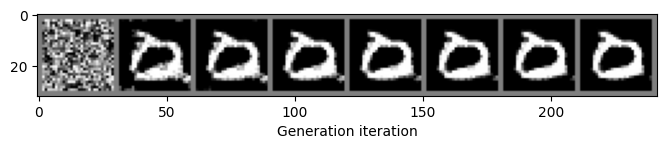

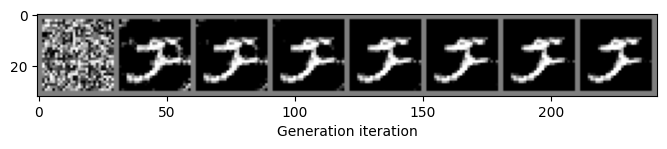

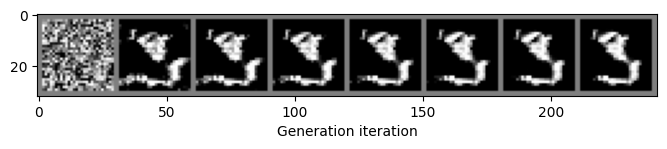

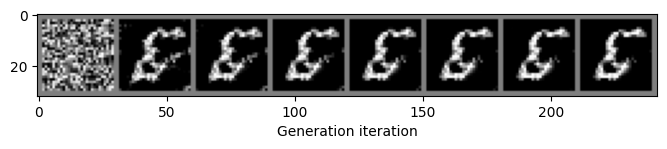

In [16]:
def generate_imgsp(pl_module):
    pl_module.eval()
    start_imgs = torch.rand((4,)+img_shape).to(device)
    start_imgs = start_imgs * 2 - 1
    torch.set_grad_enabled(True)  # Tracking gradients for sampling necessary
    imgs_per_step = sampler.generate_samples(pl_module, start_imgs, steps=257, step_size=10, return_img_per_step=True)
    torch.set_grad_enabled(False)
    pl_module.train()
    return imgs_per_step

imgs_per_step = generate_imgsp(model)
imgs_per_step = imgs_per_step.cpu()

for i in range(imgs_per_step.shape[1]):
    imgs_to_plot = imgs_per_step[0:256:32,i]
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.clone().cpu())
    plt.xlabel("Generation iteration")
    plt.show()

# Evaluation (20 pts)

Now lets evaluate the model more precisely.

In [17]:
import numpy as np
from scipy.spatial import distance

# Compute entropy
def compute_entropy(labels):
    """
    Compute entropy of the given labels.

    Args:
        labels: input labels (non-negative integers)

    Returns:
        entropy: computed entropy
    """
    labels = np.array(labels)
    labels -= np.min(labels) if np.min(labels) < 0 else 0
    probabilities = np.bincount(labels) / len(labels)
    probabilities = probabilities[probabilities > 0]
    return -np.sum(probabilities * np.log(probabilities))

# Compute identifiability
def compute_identifiability(orig_data, synth_data):
    """
    Compute identifiability value between original and synthetic data.

    Args:
        orig_data: original data
        synth_data: synthetically generated data

    Returns:
        identifiability_value: Identifiability metric
    """
    orig_data, synth_data = np.asarray(orig_data), np.asarray(synth_data)
    x_dim = orig_data.shape[1]

    # Compute weights
    W = np.array([compute_entropy(np.round(orig_data[:, i] * 100).astype(int)) for i in range(x_dim)])
    W /= np.sum(W)

    # Normalize data
    orig_data_hat, synth_data_hat = orig_data * W, synth_data * W

    # Compute distances
    orig_distances = distance.cdist(orig_data_hat, orig_data_hat, metric="euclidean")
    np.fill_diagonal(orig_distances, np.inf)
    nearest_orig = np.sort(orig_distances, axis=1)[:, 1]

    nearest_synth = np.min(distance.cdist(orig_data_hat, synth_data_hat, metric="euclidean"), axis=1)

    return np.sum(nearest_synth < nearest_orig) / len(orig_data)


In [24]:
import numpy as np

# Limit the number of samples to 1024
MAX_SAMPLES = 1024

# Load original data
origin_data = []
for img, _ in test_loader:
    origin_data.append(img.numpy())
    if len(origin_data) * img.shape[0] >= MAX_SAMPLES:
        break

origin_data = np.concatenate(origin_data, axis=0).reshape(-1, 28 * 28)

# Generate synthetic data
synth_data = []
for _ in range(MAX_SAMPLES // BATCH_SIZE):
    img = generate_image(model, sampler, BATCH_SIZE).squeeze().cpu().detach().numpy()
    synth_data.append(img)

synth_data = np.concatenate(synth_data, axis=0).reshape(-1, 28 * 28)

# Compute and print identifiability value
identifiability_value = compute_identifiability(origin_data, synth_data)
print(identifiability_value)

Generating Samples: 100%|██████████| 64/64 [00:33<00:00,  1.91it/s]


0.0068359375


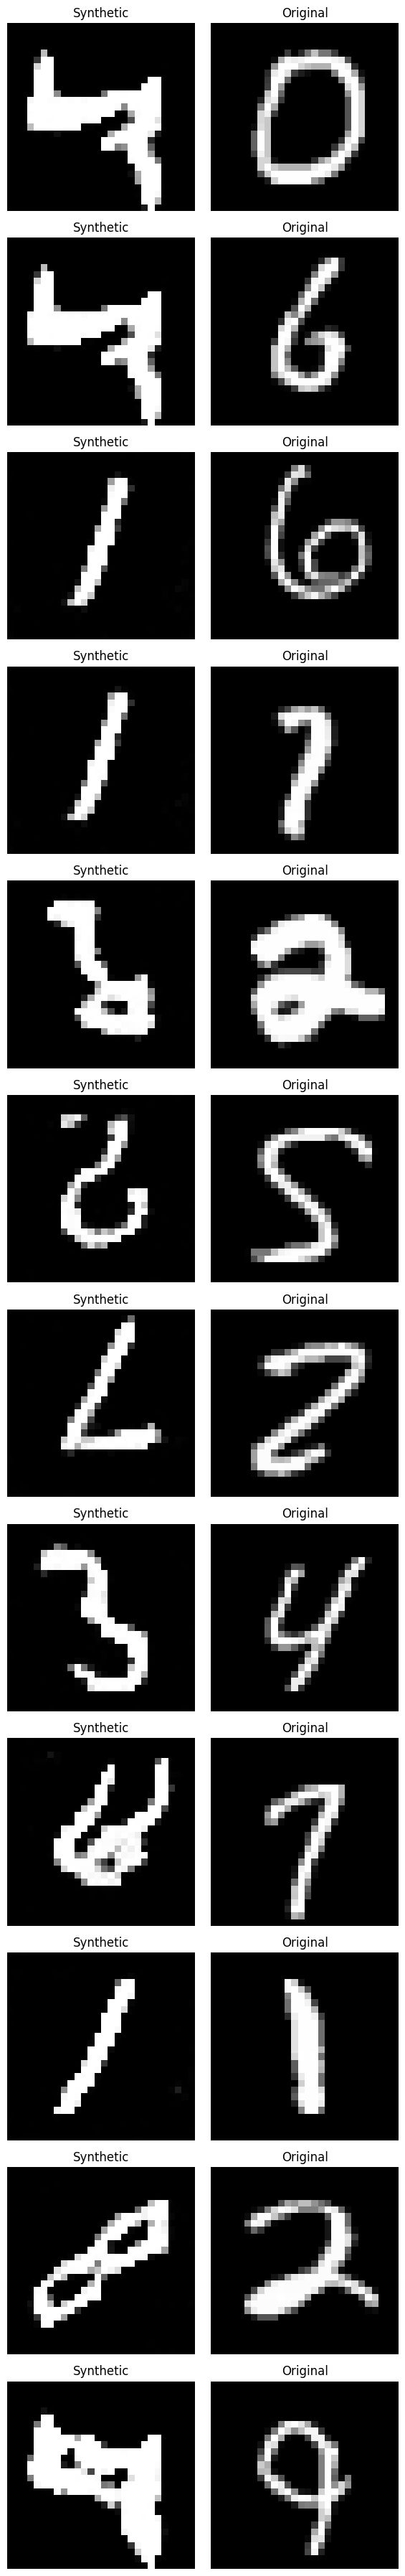

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples to plot
num_samples = 12  # Adjust as needed

# Define specific indices for image selection
indices = [10, 50, 100, 111, 222, 333, 444, 555, 666, 777, 888, 999][:num_samples]

# Ensure we don't exceed the available data size
max_index = min(len(origin_data), len(synth_data))
indices = [idx for idx in indices if idx < max_index]

# Create subplots
fig, axes = plt.subplots(len(indices), 2, figsize=(6, 3 * len(indices)))

for i, idx in enumerate(indices):
    for j, (data, title) in enumerate(zip([synth_data, origin_data], ["Synthetic", "Original"])):
        axes[i, j].imshow(data[idx].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(title)

plt.tight_layout()
plt.show()